In [1]:
import spacy
import pandas as pd
import numpy as np

import Modules.solrhandler as sh
#import Modules.decision_tree_bot as cb

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Import eval.csv
import os
file = os.path.realpath("../../Evaluierung/eval.csv")
eval = pd.read_csv(file, sep = ";")
eval.head()

,documentId,file,dialogId,initialQuestion,suggestionCount,directlyFound,name
0,120697,20220131--quantEvalAllExcel.xlsx,4,Ummeldung,6,True,Änderung/Wechsel der Hauptwohnung
1,120686,20220131--quantEvalAllExcel.xlsx,4,Ummelden,6,True,Anmeldung einer Wohnung
2,329421,20220131--quantEvalAllExcel.xlsx,19,Pcr test positiv brauche ich eine Krankschreib...,6,False,Erstattung nach Infektionsschutzgesetz bei Tät...
3,329421,20220131--quantEvalAllExcel.xlsx,19,Quarantäne Krankschreibung vom Arzt,6,True,Erstattung nach Infektionsschutzgesetz bei Tät...
4,120914,20220131--quantEvalAllExcel.xlsx,23,Termin für Zulassung Gebrauchtwagen,6,True,Zulassung eines Fahrzeuges mit auswärtigem Ken...


Funktionen

In [3]:
def findCorrectAnswer(chatbot,targetService): # NEU
    temp = chatbot.df
    
    if(not any(temp["id"] == str(targetService))):
        return None
    
    index = temp.index[temp["id"] == str(targetService)].tolist()[0]

    bin_vector = chatbot.getBinVector(right = True)
    if bin_vector[index] == 1:
        return True
    
    bin_vector = chatbot.getBinVector(right = False)
    if bin_vector[index] == 0:
        return None
    else:
        return False
    raise Exception("Fehler in findCorrectAnswer")

Klasse

In [4]:
import spacy
import pandas as pd
import numpy as np

import Modules.solrhandler as sh
import Modules.clusterer as cls

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree

from sklearn.tree import export_text

import matplotlib.pyplot as plt


# TODO import jannis
def init_vector(df,col_name="ssdsLemma"):
    #initiates the word-occurence & frequency vector and list of words
    vectorizer = CountVectorizer()
    a = vectorizer.fit_transform(df[f"{col_name}_processed"]).toarray()
    b = a > 0
    word_occ = b.astype(int)
    words = vectorizer.get_feature_names()
    word_freq=word_occ.sum(axis=0).tolist()
    return word_occ, words, word_freq

class DecisionTreeChatbot:


    def __init__(self,stopAtN = 3, tree_model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 1), solr = sh.SolrHandler(5), nlp = spacy.load('de_core_news_lg')):
        self.tree_model = tree_model
        self.solr = solr
        self.nlp = nlp
        self.stopAtN = stopAtN
        
        self.df = None
        self.node = 0
        
        # Jannis output
        self.matrix = None
        self.keywords = None
        self.frequencies = None
        

    def initQuery(self, query, printTree = True):
        
        self.node = 0
        
        self.df = self.solr.get_df_from_query(query)
        self.df = cls.process_df_col(self.df, "ssdsLemma", self.nlp)
        
        self.matrix, self.keywords, self.frequencies = init_vector(self.df, "ssdsLemma")
        
        self.tree_model.fit(self.matrix, self.df["id"])
        
        if printTree:
            self.printTree()

    def refine(self, answer):

        # Check if finished 
        if self.checkFinished():
            return False
        
        #refinement
        
        tree = self.tree_model.tree_

        bin_vector = self.getBinVector(answer)
        #print(np.where(bin_vector == 1)) # TODO Wrong behavior
        self.df = self.df.loc[np.where(bin_vector == 1)]#.reset_index(drop=True)
        
        if answer: 
            self.node = tree.children_right[self.node]
        else:
            self.node = tree.children_left[self.node]
            
        return not self.checkFinished()
    
    def checkFinished(self):
        return len(self.df.index) <= self.stopAtN
    
    def getBinVector(self, right = True): # gibt an welche services (keyword vorhanden) im rechten child sind [0,0,0,1] <- solr result mit index 3 ist in rechter seite von baum
        tree = self.tree_model.tree_
        if right:
            return tree.value[tree.children_right[self.node]][0]
        else:
            return tree.value[tree.children_left[self.node]][0]

    def generateQuestion(self):
        return "Geht es bei ihrem Anliegen um " + self.getKeyword() + "?"

    def getKeyword(self):
        structure = self.tree_model.tree_
        feature = structure.feature[self.node]
        return self.keywords[feature] #names[structure.feature[clf.tree_.children_right[0]]]

    def getResult(self):
        return self.df
    
    def printTree(self):
        text = export_text(self.tree_model, feature_names = self.keywords)
        print(text)
        
    def plotTree(self):
        plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
        #class_names = self.df["d115Name"]
        class_names = self.df["id"]
        tree.plot_tree(self.tree_model,feature_names = self.keywords, fontsize=10, class_names = class_names)
        plt.show()


Test init

Genesenen Bescheinigung
120702


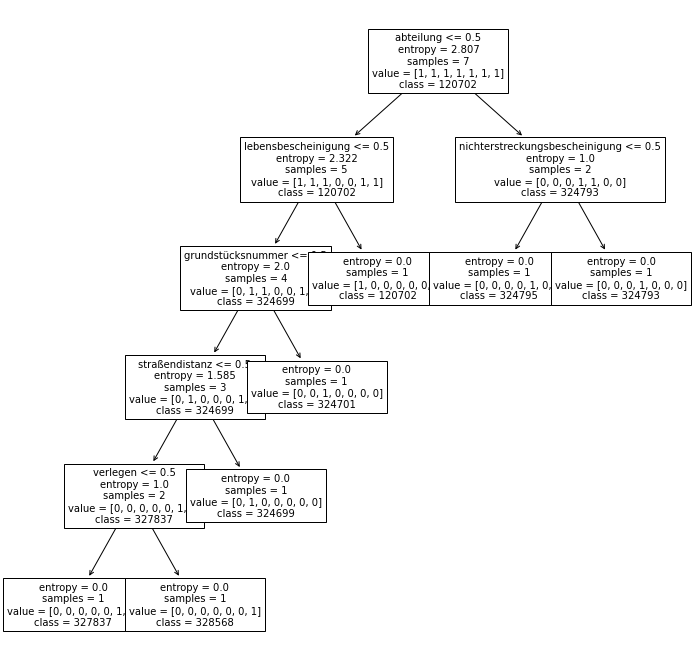

In [5]:
#query = "Quarantäne Krankschreibung vom Arzt"
#service = "329421"

index = 7 # 7

query = str(eval["initialQuestion"][index])
service = str(eval["documentId"][index])

print(query)
print(service)

solrhandler = sh.SolrHandler(7) # 900
chatbot = DecisionTreeChatbot(3,solr = solrhandler) # 3
chatbot.initQuery(query, False)
chatbot.plotTree()
#chatbot.printTree()



In [6]:
print(chatbot.generateQuestion())
print(findCorrectAnswer(chatbot, service)) # TODO FEHLER

Geht es bei ihrem Anliegen um abteilung?
False


In [7]:
chatbot.refine(True)

False

In [8]:
chatbot.refine(False)

False

In [9]:
chatbot.getResult()#["ssdsLemma"][0]

,id,d115Url,d115Name,ssdsAll,d115DocumentBoostValue,d115Description,d115Synonym,d115Position,d115InfoLaw,d115Prerequisites,...,ssdsVerrichtungDict,ssdsSynonym,ssdsSynonymDict,ssdsManualKeywords,_version_,d115Forms,leikaName,ssdsVerrichtungDetail,ssdsVerrichtungDetailDict,ssdsLemma_processed
3,324793,https://service.berlin.de/dienstleistung/324793/,Nichterstreckungsbescheinigung,"[Nichterstreckungsbescheinigung, Mit einer Nic...",1.0,Mit einer Nichterstreckungsbescheinigung kann ...,"[Nichterstreckungsbescheinigung, Belastung in ...",101,"[{""name"":""Vermessungsgebührenordnung (VermGebO...","[{""name"":""Keine Voraussetzungen erforderlich.""...",...,[Bescheinigung],"[Nichterstreckungsbescheinigung, Belastung in ...","[Nichterstreckungsbescheinigung, Belastung in ...",NaN,1727918340624613376,"[{""name"":""Der Antrag kann formlos unter Angabe...",NaN,NaN,NaN,ii abteilung grundbuch nichterstreckungsbesche...
4,324795,https://service.berlin.de/dienstleistung/324795/,Gegenstandslosigkeitsbescheinigung,"[Gegenstandslosigkeitsbescheinigung, Wenn eine...",1.0,Wenn eine in Abteilung II des Grundbuchs einge...,"[Gegenstandslosigkeitsbescheinigung, Belastung...",101,"[{""name"":""Vermessungsgebührenordnung (VermGebO...","[{""name"":""Keine Voraussetzungen erforderlich"",...",...,[Bescheinigung],"[Gegenstandslosigkeitsbescheinigung, Belastung...","[Gegenstandslosigkeitsbescheinigung, Belastung...",NaN,1727918340627759104,"[{""name"":""Der Antrag kann formlos unter Angabe...",NaN,NaN,NaN,ii abteilung grundbuch gegenstandslosigkeitsbe...


In [10]:
#chatbot.getResult()["ssdsLemma"][0]

In [11]:
TREE = chatbot.tree_model.tree_
#rechts
print(TREE.value[TREE.children_right[chatbot.node]][0])
print(TREE.value[TREE.children_left[chatbot.node]][0])

[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]


Test auto

In [12]:

query = str(eval["initialQuestion"][index])
service = str(eval["documentId"][index])

print(chatbot.generateQuestion())
answer = findCorrectAnswer(chatbot, service)
print(answer)
while chatbot.refine(answer):
    answer = findCorrectAnswer(chatbot, service)
    print(chatbot.generateQuestion())
    print(answer)
chatbot.getResult()

Geht es bei ihrem Anliegen um nichterstreckungsbescheinigung?
None


,id,d115Url,d115Name,ssdsAll,d115DocumentBoostValue,d115Description,d115Synonym,d115Position,d115InfoLaw,d115Prerequisites,...,ssdsVerrichtungDict,ssdsSynonym,ssdsSynonymDict,ssdsManualKeywords,_version_,d115Forms,leikaName,ssdsVerrichtungDetail,ssdsVerrichtungDetailDict,ssdsLemma_processed
3,324793,https://service.berlin.de/dienstleistung/324793/,Nichterstreckungsbescheinigung,"[Nichterstreckungsbescheinigung, Mit einer Nic...",1.0,Mit einer Nichterstreckungsbescheinigung kann ...,"[Nichterstreckungsbescheinigung, Belastung in ...",101,"[{""name"":""Vermessungsgebührenordnung (VermGebO...","[{""name"":""Keine Voraussetzungen erforderlich.""...",...,[Bescheinigung],"[Nichterstreckungsbescheinigung, Belastung in ...","[Nichterstreckungsbescheinigung, Belastung in ...",NaN,1727918340624613376,"[{""name"":""Der Antrag kann formlos unter Angabe...",NaN,NaN,NaN,ii abteilung grundbuch nichterstreckungsbesche...
4,324795,https://service.berlin.de/dienstleistung/324795/,Gegenstandslosigkeitsbescheinigung,"[Gegenstandslosigkeitsbescheinigung, Wenn eine...",1.0,Wenn eine in Abteilung II des Grundbuchs einge...,"[Gegenstandslosigkeitsbescheinigung, Belastung...",101,"[{""name"":""Vermessungsgebührenordnung (VermGebO...","[{""name"":""Keine Voraussetzungen erforderlich"",...",...,[Bescheinigung],"[Gegenstandslosigkeitsbescheinigung, Belastung...","[Gegenstandslosigkeitsbescheinigung, Belastung...",NaN,1727918340627759104,"[{""name"":""Der Antrag kann formlos unter Angabe...",NaN,NaN,NaN,ii abteilung grundbuch gegenstandslosigkeitsbe...


In [13]:
i = 4
while i <= 4:

    query = str(eval["initialQuestion"][i])
    service = str(eval["documentId"][i])
    print(query)
    
    chatbot.initQuery(query, False)

    print(chatbot.generateQuestion())
    answer = findCorrectAnswer(chatbot, service)
    print(answer)
    while chatbot.refine(answer):
        answer = findCorrectAnswer(chatbot, service)
        
        print(chatbot.generateQuestion())
        print(answer)
    chatbot.getResult()
    i+=1
    

Termin für Zulassung Gebrauchtwagen
Geht es bei ihrem Anliegen um halterwechsel?
False
Geht es bei ihrem Anliegen um neuzulassung?
True


Logging

In [14]:
def getRank(chatbot, targetService):
    temp = chatbot.df.reset_index()
    try:
        rank = temp.index[temp["id"]==str(targetService)].values[0]
    except IndexError as e:
        return float("NaN")
    return rank + 1

"""def getRank(chatbot, targetService):
    temp = chatbot.df.reset_index()
    print(temp["id"]==str(targetService))
    rank = temp.index[temp["id"]==str(targetService)].values[0]

    return rank"""

class Logger:
    
    def __init__(self, chatbot, eval_df):
        self.liste = []
        self.chatbot = chatbot
        self.eval_df = eval_df
    
    def getDataFrame(self): # TODO
        pass
    
    def log(self, ID, t, row, answer = None): 
        target_service = row["documentId"]
        
        dialogId = row["dialogId"]
        file = row["file"]
        
        service_name = row["name"]
        query = row["initialQuestion"]
        
        if t == 0:
            pass
            
        
        if answer is not None:

            
            nResults = len(self.chatbot.df.index)
            question = self.chatbot.generateQuestion()
            answer = answer

            rank = getRank(self.chatbot,str(target_service))# getRank(target_service)
            
            row = (file, dialogId, ID, t,  service_name, query, question, answer, rank, nResults)
        else:
            #nInitialResults = len(chatbot.df.index)
            #initialRank = np.nan
            row = (file, dialogId, ID, t, service_name, query, None, None, None, None)
        self.liste.append(row)
        #print(self.liste)
        #print(str(row))

Execution

In [23]:
# Initialisierung Komponenten Chatbot
solrhandler = sh.SolrHandler(1000)
chatbot = DecisionTreeChatbot(stopAtN = 3, solr = solrhandler) #TODO

In [24]:
# Experiment durchlaufen und Loggen
sub_eval = eval.head(10)
lg = Logger(chatbot,sub_eval)   

for (ID, row) in sub_eval.iterrows():
    
    print(ID)
    
    # fun
    query = row["initialQuestion"]
    target_service = str(row["documentId"])
    
    # Log
    #chatbot = DecisionTreeChatbot(solr = solrhandler) # TODO
    try:
        chatbot.initQuery(query, False)
    except Exception as e:
        if(str(e) == 'response'): # TODO ??
            next
        elif(str(e) == 'no solr output'):
            next
        else:
            print(e)
    t = 0
    answer = findCorrectAnswer(chatbot, target_service)
    
    lg.log(ID,t, row, answer)
    
    if answer is None:
        continue
    
    while chatbot.refine(answer):
        
        # log
        t += 1
        answer = findCorrectAnswer(chatbot, target_service)
        lg.log(ID, t, row,answer)
        
        if answer is None:
            
            break
            
    lg.log(ID, t+1, row,answer) # Endlog

0
1
2
3
4
5
6
7
8
9


In [25]:
log_df = pd.DataFrame(lg.liste, columns=["file","dialogId", "ID","t", "service_name", "query", "question", "answer", "rank", "nResults"])
log_df

,file,dialogId,ID,t,service_name,query,question,answer,rank,nResults
0,20220131--quantEvalAllExcel.xlsx,4,0,0,Änderung/Wechsel der Hauptwohnung,Ummeldung,Geht es bei ihrem Anliegen um kfz?,True,3.0,7.0
1,20220131--quantEvalAllExcel.xlsx,4,0,1,Änderung/Wechsel der Hauptwohnung,Ummeldung,Geht es bei ihrem Anliegen um halter?,True,2.0,3.0
2,20220131--quantEvalAllExcel.xlsx,4,1,0,Anmeldung einer Wohnung,Ummelden,None,None,NaN,NaN
3,20220131--quantEvalAllExcel.xlsx,19,2,0,Erstattung nach Infektionsschutzgesetz bei Tät...,Pcr test positiv brauche ich eine Krankschreib...,Geht es bei ihrem Anliegen um approbation?,True,4.0,13.0
4,20220131--quantEvalAllExcel.xlsx,19,2,1,Erstattung nach Infektionsschutzgesetz bei Tät...,Pcr test positiv brauche ich eine Krankschreib...,Geht es bei ihrem Anliegen um prüfung?,True,4.0,7.0
5,20220131--quantEvalAllExcel.xlsx,19,2,2,Erstattung nach Infektionsschutzgesetz bei Tät...,Pcr test positiv brauche ich eine Krankschreib...,Geht es bei ihrem Anliegen um ärztlich?,False,3.0,4.0
6,20220131--quantEvalAllExcel.xlsx,19,2,3,Erstattung nach Infektionsschutzgesetz bei Tät...,Pcr test positiv brauche ich eine Krankschreib...,Geht es bei ihrem Anliegen um tierärztlich?,False,2.0,2.0
7,20220131--quantEvalAllExcel.xlsx,19,3,0,Erstattung nach Infektionsschutzgesetz bei Tät...,Quarantäne Krankschreibung vom Arzt,Geht es bei ihrem Anliegen um arzt?,True,1.0,10.0
8,20220131--quantEvalAllExcel.xlsx,19,3,1,Erstattung nach Infektionsschutzgesetz bei Tät...,Quarantäne Krankschreibung vom Arzt,Geht es bei ihrem Anliegen um prüfung?,True,1.0,4.0
9,20220131--quantEvalAllExcel.xlsx,19,3,2,Erstattung nach Infektionsschutzgesetz bei Tät...,Quarantäne Krankschreibung vom Arzt,Geht es bei ihrem Anliegen um berlin?,True,1.0,2.0


Statistics

In [26]:
# avg Rank Improvement in turn t
log_df["rank_improvement"] = log_df.groupby(["ID"])["rank"].diff()
log_df.groupby(["t"])["rank_improvement"].mean()

t
0          NaN
1    -0.833333
2    -0.800000
3    -0.750000
4    -0.666667
5    -1.000000
6    -1.000000
7    -2.000000
8    -1.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
Name: rank_improvement, dtype: float64

In [27]:
# avg nSuggestions Improvement in turn t
log_df["sugg_improvement"] = log_df.groupby(["ID"])["nResults"].diff()
log_df.groupby(["t"])["sugg_improvement"].mean()

t
0           NaN
1    -18.833333
2    -12.000000
3     -6.000000
4     -4.666667
5     -3.000000
6     -3.000000
7     -3.000000
8     -2.000000
9     -2.000000
10    -2.000000
11    -2.000000
12    -8.000000
Name: sugg_improvement, dtype: float64

In [28]:
# MRR ohne cluster refinement
df = log_df.loc[log_df["t"] == 0]
MRR_ohne = 1/(df["rank"].mean())
MRR_ohne

0.20689655172413796

In [29]:
# MRR mit cluster refinement
df = log_df.groupby(["ID"]).last("t")
MRR_mit = 1/(df["rank"].mean())
MRR_mit
#df.head()

0.6666666666666666

In [30]:
print(log_df["t"].mean())

# bei durchschnittlich nResults
print(log_df.groupby(["ID"]).last("t")["nResults"].mean())

3.054054054054054
2.3333333333333335
